In [ ]:
!pip install kaggle

In [ ]:
#GPU count and name
!nvidia-smi -L

#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache"

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"

#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'


#hard disk space that we can use
!df -h / | awk '{print $4}'

GPU 0: Tesla T4 (UUID: GPU-6fa82a40-3d82-c19c-138d-df3d325e3458)
Fri Sep 11 10:13:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                       

In [ ]:
# if you are working on colab ,Upload kaggle.json file from your kaggle profil so that you can import the dataset directly from kaggle
from google.colab import files
files.upload()

In [ ]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 99% 394M/398M [00:06<00:00, 34.0MB/s]
100% 398M/398M [00:06<00:00, 64.6MB/s]


In [ ]:
!unzip /content/face-mask-detection.zip

In [ ]:
# Apex install
#uncomment this line
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

In [ ]:
!pip install --upgrade pip
!pip install xmltodict

     |████████████████████████████████| 1.5MB 5.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict

In [ ]:
def parse_xml(label_path):
    
    #CREDIT: kaggle.com/dohunkim
     
    x = xmltodict.parse(open(label_path , 'rb'))
    item_list = x['annotation']['object']
    
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
        
    result = []
    
    for item in item_list:
        name = item['name']
        bndbox = [int(item['bndbox']['xmin']), int(item['bndbox']['ymin']),
                  int(item['bndbox']['xmax']), int(item['bndbox']['ymax'])]       
        result.append([name, bndbox])
    
    #size = [int(x['annotation']['size']['width']), 
    #        int(x['annotation']['size']['height'])]
    
    return result #, size

In [ ]:
from matplotlib import patches
datadir='/content/annotations/'
def visualize_image(image_path, bndbox=True):
    
    #CREDIT: kaggle.com/dohunkim

    fig = plt.figure()

    #add axes to the image
    ax = fig.add_axes([0,0,1,1])

    #image_path, label_path = get_path(image_name,fold)
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

    except:
        print('error')
    
    if bndbox:
        name=os.path.basename(image_path[:len(image_path)-4])
        label_path = datadir + name + '.xml'
        labels = parse_xml(label_path)
        #thickness = int(sum(size)/400.)
        #print(thickness)        
        for label in labels:
            name, bndbox = label
            
            if name == 'with_mask':
                edgecolor = 'r'
                ax.annotate('with_mask', xy=(bndbox[2]-40,bndbox[1]+20))
            elif name == 'without_mask':
                edgecolor = 'r'
                ax.annotate('without_mask', xy=(bndbox[2]-40,bndbox[1]+20))
            else: # name == 'none'
                edgecolor = 'g'
                ax.annotate('none', xy=(bndbox[2]-40,bndbox[1]+20))
            rect = patches.Rectangle((bndbox[0],bndbox[1]), bndbox[2]-bndbox[0], bndbox[3]-bndbox[1], edgecolor = edgecolor, facecolor = 'none')    
            ax.add_patch(rect)


In [ ]:
paths=[]
names=[]
for i in os.listdir('/content/images/'):
  pathe=os.path.join('/content/images/',i)
  name=os.path.basename(pathe[:len(pathe)-4])
  paths.append(pathe)
  names.append(name)

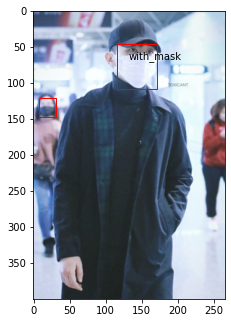

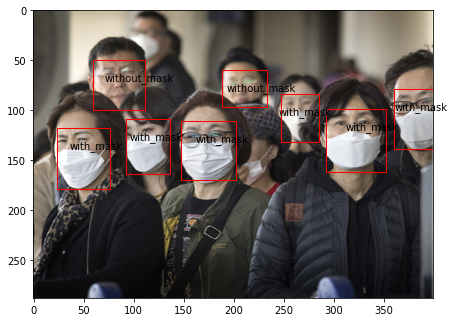

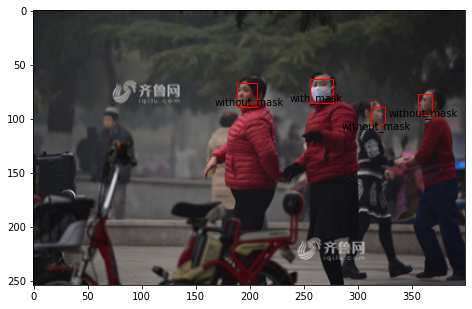

In [ ]:
NUM_OF_IMGS_TO_VISUALIZE = 3
#image_names,folds=getImageNames()
for i in paths[:NUM_OF_IMGS_TO_VISUALIZE]:
    visualize_image(i)

In [ ]:
import pandas as pd
df=pd.DataFrame(columns=['image_id','xmin','ymin','xmax','ymax','classes','width','height'])

In [ ]:
datadir='/content/annotations/'
folder='/content/'
size={}
for img in os.listdir(datadir):
    fullpath=os.path.join(datadir,img)
    extension = fullpath[len(fullpath) - 4:]
    name=img[:len(img)-4]
    
    
    if extension == '.xml':
        r=parse_xml(fullpath)
        image = cv2.imread(folder+'images/'+name+ '.png')
        s=image.shape
        size[name] = s
        for i in range(len(r)):
            dicte={
                'image_id':[name],
                'xmin':[r[i][1][0]],
                'ymin':[r[i][1][1]],
                'xmax':[r[i][1][2]],
                'ymax':[r[i][1][3]],
                'classes':[r[i][0]],
                'width':size[name][1],
                'height':size[name][0],
                }
            dat=pd.DataFrame(dicte)
            df=pd.concat([df,dat])
        
    

In [ ]:
df['classes'].unique()

array(['with_mask', 'without_mask', 'mask_weared_incorrect'], dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder =LabelEncoder() 
df['classes']= label_encoder.fit_transform(df['classes']) 

for i in ['xmin','ymin','xmax','ymax','classes','width','height']:
    df[i]=df[i].astype(float)

In [ ]:
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['x_center'] = df['xmin'] + df['w']/2
df['y_center'] = df['ymin'] + df['h']/2
#normalisation
df['x_center']=df['x_center'] / df['width']
df['w']=df['w'] / df['width']
df['y_center'] =df['y_center'] / df['height']
df['h']=df['h'] / df['height']


#from tqdm.auto import tqdm
import shutil as sh
df = df[['image_id','xmin', 'ymin', 'w', 'h','x_center','y_center','classes','width','height']]

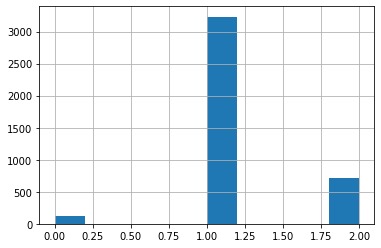

In [ ]:
df['classes'].hist()

In [ ]:
data=pd.DataFrame(names,columns=['image_id'])
train=data.iloc[:700,:]
test=data.iloc[700:,:]

In [ ]:
traindf=pd.merge(train,df,on=['image_id'],how='left')
testdf=pd.merge(test,df,on=['image_id'],how='left')

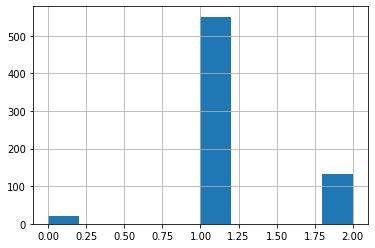

In [ ]:
testdf['classes'].hist()

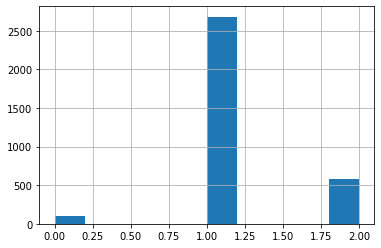

In [ ]:
traindf['classes'].hist()

In [ ]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

In [ ]:
train_dir='/content/train/'
test_dir='/content/test/'

createDirectory(train_dir)
createDirectory(test_dir)

In [ ]:
datadir='/content/images/'
for img in train['image_id']:
    fullpath=os.path.join(datadir,img +'.png')
    print(fullpath)
    image=cv2.imread(fullpath)
    cv2.imwrite(train_dir + img + '.png', image)


for img in test['image_id']:
    fullpath=os.path.join(datadir,img +'.png')
    print(fullpath)
    image=cv2.imread(fullpath)
    cv2.imwrite(test_dir + img + '.png', image)


In [ ]:
#!rm -rf /content/test/

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r yolov5/requirements.txt  # install dependencies

In [ ]:
!unzip config

Archive:  config.zip
   creating: config/
   creating: config/configyolo5v1/
  inflating: config/configyolo5v1/yolov5x.yaml  
  inflating: config/configyolo5v1/wheat4.yaml  
  inflating: config/configyolo5v1/wheat3.yaml  
  inflating: config/configyolo5v1/wheat2.yaml  
  inflating: config/configyolo5v1/wheat1.yaml  
  inflating: config/configyolo5v1/wheat0.yaml  
   creating: config/yolov5yaml/
  inflating: config/yolov5yaml/yolov5xx.yaml  


In [ ]:
import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import os
from tqdm.auto import tqdm
import shutil as sh

index =  list(sorted(set(traindf.image_id)))
source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(traindf.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/content/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/content/convertor/fold{}/labels/'.format(fold)+path2save)

            if not os.path.exists('/content/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt"):   
              with open('/content/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                  row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                  row = row.astype(str)
                  for j in range(len(row)):
                      text = ' '.join(row[j])
                      f.write(text)
                      f.write("\n")
            if not os.path.exists('/content/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/content/convertor/fold{}/images/{}'.format(fold,path2save))

            if not os.path.exists('/content/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name)):    
              sh.copy("/content/train/{}.png".format(name),'/content/convertor/fold{}/images/{}/{}.png'.format(fold,path2save,name))

In [ ]:
import yaml
a_yaml_file = open("/content/config/configyolo5v1/wheat0.yaml")
parsed_yaml_file = yaml.load(a_yaml_file, Loader=yaml.FullLoader)
parsed_yaml_file

{'names': ['wheat'],
 'nc': 1,
 'train': './convertor/fold0/images/train2017/',
 'val': './convertor/fold0/images/val2017/'}

In [ ]:
import yaml
d = {'train':'/content/convertor/fold0/images/train2017/','val':'/content/convertor/fold0/images/val2017/', 'nc':3, 'names':['mask_weared_incorrect','with_mask','without_mask']}
with open('/content/config/configyolo5v1/wheat0.yaml', 'w') as yaml_file:
    yaml.dump(d, yaml_file, default_flow_style=False)

In [ ]:
os.chdir('/content/yolov5/')
!git checkout b569ed6

Note: checking out 'b569ed6'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at b569ed6 pretrained model loading bug fix (#450)


In [ ]:
!python /content/yolov5/train.py --img 416 --batch 2 --epochs 100 --data "/content/config/configyolo5v1/wheat0.yaml" --cfg "/content/yolov5/models/yolov5s.yaml"   --name yolov5x_fold0 --weights yolov5x.pt 

Using CUDA Apex device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Namespace(batch_size=2, bucket='', cache_images=False, cfg='/content/yolov5/models/yolov5s.yaml', data='/content/config/configyolo5v1/wheat0.yaml', device='', epochs=100, evolve=False, hyp='', img_size=[416, 416], local_rank=-1, multi_scale=False, name='yolov5x_fold0', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=2, weights='yolov5x.pt', world_size=1)
Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
2020-09-11 10:20:56.923230: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'optimizer': 'SGD', 'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.utils import plot_results; plot_results()  # plot results.txt as results.png
Image(filename='./results.png', width=1000)  # view results.png

In [ ]:
!python '/content/yolov5/detect.py' --weights '/content/yolov5/runs/exp0_yolov5x_fold0/weights/best_yolov5x_fold0.pt' --img 416 --conf 0.1 --source '/content/test/'


In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/inference/output/*.png'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cp /content/yolov5/runs/exp0_yolov5s_results/weights/best.pt /content/gdrive/My\ Drive